##ECE M214A Project: Speaker Region Identification



In this project, we'll train a machine learning algorithm to classify speakers by regional dialect.  We will use speech samples from the Corpus of Regional African American Language (CORAAL - https://oraal.uoregon.edu/coraal) with speakers each belonging to one of five different US cities: 1) Rochester, NY (ROC), 2) Lower East Side, Manhattan, NY (LES), 3) Washington DC (DCB), 4) Princeville, NC (PRV), or 5) Valdosta, GA (VLD).

The project files can be downloaded from [this link](https://ucla.box.com/s/332ewjf1fjmod77c4r2b7c1zq8j1a9pp)

To do this, we will first extract features from the audio files and then train a classifier to predict the city of origin of the utterance's speaker.  The goal is to extract a feature that contains useful information about regional dialect characteristics.

##1. Setting up the data directories and Google Colab

Find the data for this project here: https://drive.google.com/drive/folders/1DRiIxfj5G6VzfHr1ojXxeE1YdLbae5xH?usp=sharing and store a copy in your google drive.  

Make sure that the 'project_data' folder is stored in the top level of your google drive.  Otherwise, you will need to change the corresponding paths in the remainder of the notebook.

Mount your google drive. This will give this notebook read/write access to data stored in your google drive.  You can either do this in the file browser on the left side of this notebook or by running the code snippet below. 

It is recommended that you use your UCLA google account for this project, as it has more storage than a standard google account.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

To run this project on your local system, replace the corresponding file paths to the locations of the project files on your local machine

## 2. Getting familiar with the data


Let's take a moment to understand the data.  The original CORAAL dataset consists of ~85 different speakers, each from one of five cities.  The audio files are names with the convention: DCB_se1_ag1_f_03.  Here, DCB is the city code, se1 denotes the socioeconomic group of the speaker, ag1 denotes the age group of the speaker, f denotes female, and 03 denotes the participant number.  These unique combinations of identifiers mark the speaker.  

The dataset has been preprocessed to only include audio segments greater than 10 seconds in length. there are a number of audio snippets of at least 10sec in length.  Those segments are numbered with the appending tag _seg_number for each segment.

You can also try listening to any segment like this:

In [2]:
# from IPython.display import Audio

# sr = 44100

# Audio(filename= "C:/Users/xings/Downloads/ECE M214A Winter 2023 Project/project_data/train_clean/DCB_se1_ag1_f_03_1_seg_3.wav", rate=sr)

The original dataset has also been split into a train and test set. The test set has been further split, with a portion corrupted with the addition of 10dB babble noise:

In [3]:
# sr = 44100

# Audio(filename= "C:/Users/xings/Downloads/ECE M214A Winter 2023 Project/project_data/test_noisy/LES_se0_ag3_f_01_1_seg_57.wav", rate=sr)

## 3. Feature Extraction

As a baseline, we will be using the average mfcc value over time from the Librosa Python library. Your job will be to choose better features to improve performance on both the clean and noisy data

We first define a pair of functions to create features and labels for our classification model:


In [4]:
import numpy as np
import pandas as pd
import os, time, audb
import audiofile, torchaudio
import librosa, opensmile
from glob import glob
from tqdm import tqdm

def extract_feature(audio_file, n_mfcc=13):

    '''
  Function to extract features from a single audio file given its path
  Modify this function to extract your own custom features
  '''

    audio, fs = audiofile.read(
        audio_file,
        always_2d=True,
    )
  # replace the following features with your own
    # Below is a toolkit from openSMILE and 
    # We do the extraction for the entire feature set (total of 88)
    # along with additional features from librosa
    # which are melspectrogram, zero_crossing_rate, lpc, mfccs
    # along with their mean and median
    
    # openSMILE features
    smile = opensmile.Smile(feature_set=opensmile.FeatureSet.eGeMAPSv02,
                            feature_level=opensmile.FeatureLevel.Functionals,
                           )
    features=smile.process_signal(audio,fs)
    feat_out_openSMILE = features.to_numpy()
    
    # librosa features
    audio,fs = torchaudio.load(audio_file)
    audio = audio.numpy().reshape(-1)
    mels = librosa.feature.melspectrogram(y=audio, sr=fs)
    zcr = librosa.feature.zero_crossing_rate(audio)
    lpc = librosa.lpc(y=audio, order=12)
    mfccs = librosa.feature.mfcc(y=audio, sr=fs, n_mfcc=13)
    feat_out_1 = np.append(np.array([np.nanmean(mels)]), np.array([np.nanmean(zcr)]))
    feat_out_2 = np.append(np.array([lpc]),np.array(np.nanmean(mfccs, axis=1)))
    feat_out_3 = np.append(np.array([np.nanmedian(mels)]), np.array([np.nanmedian(zcr)]))
    feat_out_4 = np.array(np.nanmedian(mfccs, axis=1))
    feat_out_librosa_mean = np.append(feat_out_1,feat_out_2)
    feat_out_librosa_median = np.append(feat_out_3,feat_out_4)
    feat_out_librosa = np.append(feat_out_librosa_mean,feat_out_librosa_median)
    
    # append both openSMILE and librosa
    feat_out = np.append(np.array(feat_out_openSMILE)[0,:],feat_out_librosa)
    # to eliminate potential nan values
    feat_out = np.nan_to_num(feat_out)
    # to eliminate potential infinity values
    feat_out = np.nan_to_num(feat_out, posinf=0)
    
    # output feature index:
    #       0-87:    openSMILE
    #       88:      melspectrogram/mean
    #       89:      zero_crossing_rate/mean
    #       90-102:  lpc
    #       103-115: mfccs/mean
    #       116:     melspectrogram/median
    #       117:     zero_crossing_rate/median
    #       118-130: mfccs/median
    return feat_out


def get_label(file_name):
  '''
  Function to retrieve output labels from filenames
  '''
  if 'ROC' in file_name:
    label=0
  elif 'LES' in file_name:
    label=1
  elif 'DC' in file_name:
    label=2
  elif 'PRV' in file_name:
    label=3
  elif 'VLD' in file_name:
    label=4
  else:
    raise ValueError('invalid file name')
  return label

C:\Users\xings\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let us now call these functions to extract the features and labels from the train_clean directory

In [5]:
# # I comment out all the feature extraction in order to save some time
# # the feature extracted data can be imported from the previous section


# #First we obtain the list of all files in the train_clean directory
# train_files = glob('C:/Users/xings/Downloads/ECE M214A Winter 2023 Project/project_data/train_clean/*.wav')

# #Let's sort it so that we're all using the same file list order
# #and you can continue processing the features from a given file if it stops
# #partway through running
# train_files.sort() 

# train_feat=[]
# train_label=[]

# for wav in tqdm(train_files):

#   train_feat.append(extract_feature(wav))
#   train_label.append(get_label(wav))

In [6]:
# #Now we obtain the list of all files in the test_clean directory
# test_clean_files = glob('C:/Users/xings/Downloads/ECE M214A Winter 2023 Project/project_data/test_clean/*.wav')

# #Similar to above, we sort the files
# test_clean_files.sort() 

# test_clean_feat=[]
# test_clean_label=[]

# for wav in tqdm(test_clean_files):

#   test_clean_feat.append(extract_feature(wav))
#   test_clean_label.append(get_label(wav))

In [7]:
# #Finally we obtain the list of all files in the test_noisy directory
# test_noisy_files = glob('C:/Users/xings/Downloads/ECE M214A Winter 2023 Project/project_data/test_noisy/*.wav')

# #Similar to above, we sort the files
# test_noisy_files.sort() 

# test_noisy_feat=[]
# test_noisy_label=[]

# for wav in tqdm(test_noisy_files):

#   test_noisy_feat.append(extract_feature(wav))
#   test_noisy_label.append(get_label(wav))

In [8]:
# Get the chosen feature's names
import pickle
with open('pickle_feat_names.data','rb') as f:
    feat_names = pickle.load(f)

In [9]:
# pickle the data for saving processing time in the future

import pickle
# with open('pickle_train_feat.data', 'wb') as f:
#     pickle.dump(train_feat, f)
# with open('pickle_train_label.data', 'wb') as f:
#     pickle.dump(train_label, f)
# with open('pickle_test_clean_feat.data', 'wb') as f:
#     pickle.dump(test_clean_feat, f)
# with open('pickle_test_clean_label.data', 'wb') as f:
#     pickle.dump(test_clean_label, f)
# with open('pickle_test_noisy_feat.data', 'wb') as f:
#     pickle.dump(test_noisy_feat, f)
# with open('pickle_test_noisy_label.data', 'wb') as f:
#     pickle.dump(test_noisy_label, f)

In [10]:
# import data from pickle files
# the data contains 88 features from openSMILE
# along with additional features from librosa

import pickle
with open('pickle_train_feat.data','rb') as f:
    train_feat = pickle.load(f)
with open('pickle_train_label.data','rb') as f:
    train_label = pickle.load(f)
with open('pickle_test_clean_feat.data','rb') as f:
    test_clean_feat= pickle.load(f)
with open('pickle_test_clean_label.data','rb') as f:
    test_clean_label = pickle.load(f)
with open('pickle_test_noisy_feat.data','rb') as f:
    test_noisy_feat= pickle.load(f)
with open('pickle_test_noisy_label.data','rb') as f:
    test_noisy_label = pickle.load(f)

## 4. Model Training and Predictions

Now we'll train the backend system to predict the regions from the input features.  We'll use an xgboosted decision tree for this.  An advantage of this model is that we can also parse the decision tree and measure the impact of different features in the end result for explainability

In [11]:
#Install shap library
!pip install shap


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
# # This cell is only for test
# # DO NOT COMMENT IN THIS CELL UNLESS YOU ARE TESTING
# # DO NOT COMMENT IN THIS CELL UNLESS YOU ARE TESTING
# # Test for the importance of each feature from the sets
# # by adding features according to the impact on the result accuracy

# clean_th=0
# noisy_th=0
# index = []
# with open('pickle_train_feat.data','rb') as f:
#     train_feat = pickle.load(f)
# with open('pickle_train_label.data','rb') as f:
#     train_label = pickle.load(f)
# with open('pickle_test_clean_feat.data','rb') as f:
#     test_clean_feat= pickle.load(f)
# with open('pickle_test_clean_label.data','rb') as f:
#     test_clean_label = pickle.load(f)
# with open('pickle_test_noisy_feat.data','rb') as f:
#     test_noisy_feat= pickle.load(f)
# with open('pickle_test_noisy_label.data','rb') as f:
#     test_noisy_label = pickle.load(f)
# feat_num = len(train_feat[0])
# print('0.930648769574944 0.8242074927953891')
# for i in range(88):
#     ind = list(range(88, 90))+list(range(103,131))
#     ind.append(2)
#     ind.append(62)
#     ind.append(79)
#     ind.append(41)
#     ind.append(20)
#     ind.append(59)
#     ind.append(i)
# #     print(ind)
# #     [13,1,62,2,28,59]
#     train_feat_test=np.array(train_feat)[:,ind]
#     test_clean_feat_test=np.array(test_clean_feat)[:,ind]
#     test_noisy_feat_test=np.array(test_noisy_feat)[:,ind]
    
    
#     feat_names=['test_' +str(n) for n in range(len(ind))]
#     train_feat_df = pd.DataFrame(data=np.stack(train_feat_test), columns=feat_names)
#     y_train=np.stack(train_label)
#     test_clean_feat_df = pd.DataFrame(data=np.stack(test_clean_feat_test), columns=feat_names)
#     y_test_clean=np.stack(test_clean_label)
#     test_noisy_feat_df = pd.DataFrame(data=np.stack(test_noisy_feat_test), columns=feat_names)
#     y_test_noisy=np.stack(test_noisy_label)
                
#     # create a parameter to achieve gpu acceleration for XGBClassifier
#     model = xgboost.XGBClassifier(tree_method='gpu_hist')
#     model.fit(train_feat_df,y_train)

#     clean_accu = np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean)
#     noisy_accu = np.sum(y_test_noisy==model.predict(test_noisy_feat_df))/len(y_test_noisy)
#     if clean_accu+noisy_accu > clean_th+noisy_th:
#         clean_th = clean_accu
#         noisy_th = noisy_accu
#         print(i,'VALID')
#     print(i,clean_accu,noisy_accu)

In [13]:
# The features we actually used for the training process

with open('pickle_feat_names.data','rb') as f:
    feat_names = pickle.load(f)
print(np.array(feat_names)[[88, 89, 103, 104, 105, 106, 107, 108,
                            109, 110, 111, 112, 113, 114, 115, 116,
                            117, 118, 119, 120, 121, 122, 123, 124,
                            125, 126, 127, 128, 129, 130, 2, 62, 79,
                            41, 20, 59]])

['melspectrogram/mean' 'zero_crossing_rate/mean' 'mfccs_mean_0'
 'mfccs_mean_1' 'mfccs_mean_2' 'mfccs_mean_3' 'mfccs_mean_4'
 'mfccs_mean_5' 'mfccs_mean_6' 'mfccs_mean_7' 'mfccs_mean_8'
 'mfccs_mean_9' 'mfccs_mean_10' 'mfccs_mean_11' 'mfccs_mean_12'
 'melspectrogram/median' 'zero_crossing_rate/median' 'mfccs_median_0'
 'mfccs_median_1' 'mfccs_median_2' 'mfccs_median_3' 'mfccs_median_4'
 'mfccs_median_5' 'mfccs_median_6' 'mfccs_median_7' 'mfccs_median_8'
 'mfccs_median_9' 'mfccs_median_10' 'mfccs_median_11' 'mfccs_median_12'
 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0' 'slopeV0-500_sma3nz_amean'
 'slopeUV500-1500_sma3nz_amean' 'F1frequency_sma3nz_stddevNorm'
 'spectralFlux_sma3_amean' 'alphaRatioV_sma3nz_stddevNorm']


In [14]:
import xgboost
import numpy as np
import shap
import pandas as pd

#Format input data

# the feature indices
feat_index = [88, 89, 103, 104, 105, 106, 107, 108,
         109, 110, 111, 112, 113, 114, 115, 116,
         117, 118, 119, 120, 121, 122, 123, 124,
         125, 126, 127, 128, 129, 130, 2, 62, 79,
         41, 20, 59]

# import feature data and label
with open('pickle_train_feat.data','rb') as f:
    train_feat = pickle.load(f)
with open('pickle_train_label.data','rb') as f:
    train_label = pickle.load(f)
with open('pickle_test_clean_feat.data','rb') as f:
    test_clean_feat= pickle.load(f)
with open('pickle_test_clean_label.data','rb') as f:
    test_clean_label = pickle.load(f)
with open('pickle_test_noisy_feat.data','rb') as f:
    test_noisy_feat= pickle.load(f)
with open('pickle_test_noisy_label.data','rb') as f:
    test_noisy_label = pickle.load(f)

# select only on the chosen features
train_feat=np.array(train_feat)[:,feat_index]
test_clean_feat=np.array(test_clean_feat)[:,feat_index]
test_noisy_feat=np.array(test_noisy_feat)[:,feat_index]

#Edit this variable to create a list that contains your feature names

# import feature names and select only on the chosen features
with open('pickle_feat_names.data','rb') as f:
    feat_names = pickle.load(f)
feat_names = feat_names[feat_index]

# transform np.array to pd.DataFrame
train_feat_df = pd.DataFrame(data=np.stack(train_feat), columns=feat_names)
y_train=np.stack(train_label)


test_clean_feat_df = pd.DataFrame(data=np.stack(test_clean_feat), columns=feat_names)
y_test_clean=np.stack(test_clean_label)


test_noisy_feat_df = pd.DataFrame(data=np.stack(test_noisy_feat), columns=feat_names)
y_test_noisy=np.stack(test_noisy_label)


#you could just pass in the matrix of features to xgboost
#but it looks prettier in the shap explainer if you format it
#as a dataframe.  


model = xgboost.XGBClassifier()
model.fit(train_feat_df,y_train)

print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df))/len(y_test_noisy))


Train Clean Acc = 1.0
Test Clean Acc = 0.930648769574944
Test Noisy Acc = 0.8242074927953891


To save a dataframe of features, uncomment and run the following block of code

In [15]:
# train_feat_df.to_csv('drive/MyDrive/current_features.csv')

To Load a preexisting dataframe of features (saved from a previous notebook), run the following cell and then train the model

In [16]:
# train_feat_df = pd.read_csv('drive/MyDrive/myfeat_train.csv')
# test_clean_feat_df = pd.read_csv('drive/MyDrive/myfeat_test_clean.csv')
# test_noisy_feat_df = pd.read_csv('drive/MyDrive/myfeat_test_noisy.csv')

The following cells are to extract features from MATLAB. Ensure that you've run the baseline once before running the cells

Saving list of train_clean, test_clean and test_noisy files 

In [17]:
# Note: we save the list of files to ensure the labels match the utterances
# You can omit this step if you plan on extracting the labels in MATLAB
# But will need to rewrite other parts of the notebook

# with open('train_files.txt', 'w') as f:
#     for line in train_files:
#         f.write(f"{line}\n")

# with open('test_clean_files.txt', 'w') as f:
#     for line in test_clean_files:
#         f.write(f"{line}\n")

# with open('test_noisy_files.txt', 'w') as f:
#     for line in test_noisy_files:
#         f.write(f"{line}\n")

After extracting features using wrapper.m, run the following cell to retrieve a dataframe containing the features

In [18]:
# train_feat_df = pd.read_csv('drive/MyDrive/myfeat_train.csv')
# test_clean_feat_df = pd.read_csv('drive/MyDrive/myfeat_test_clean.csv')
# test_noisy_feat_df = pd.read_csv('drive/MyDrive/myfeat_test_noisy.csv')

## 5. Interpreting Results and Explainability

To see the impact different features have on the model, we create a plot of the feature importances. The features are listed top to bottom in order of how important they were to the decision.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


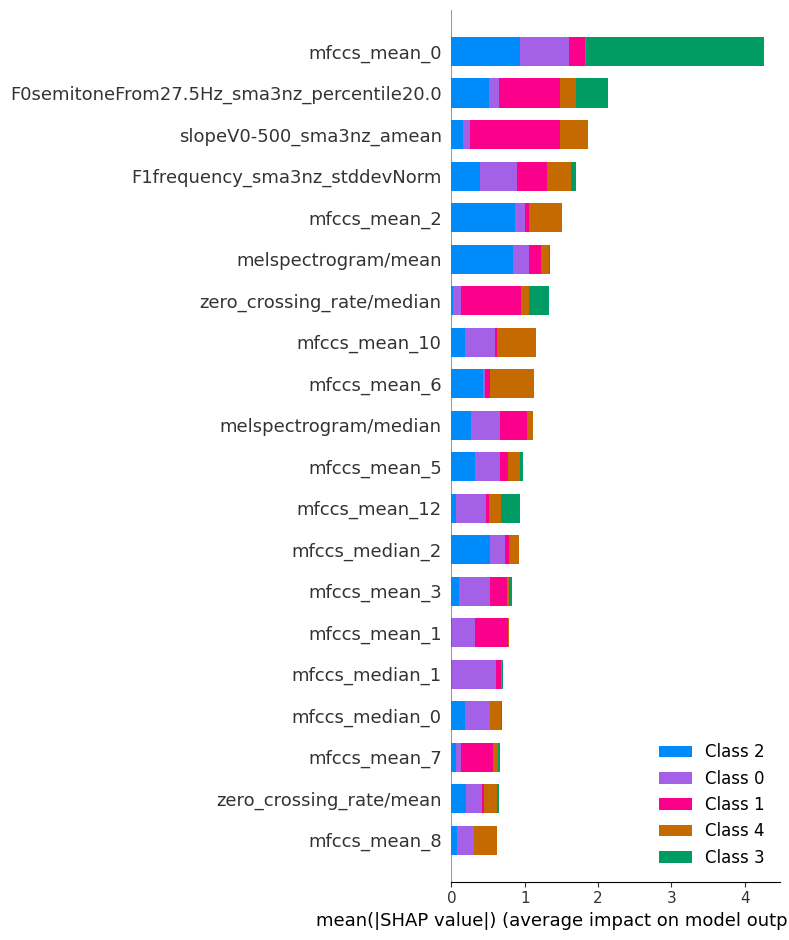

In [19]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_feat_df)
shap.summary_plot(shap_values, train_feat_df)

And we can see a confusion matrix of the mispredictions

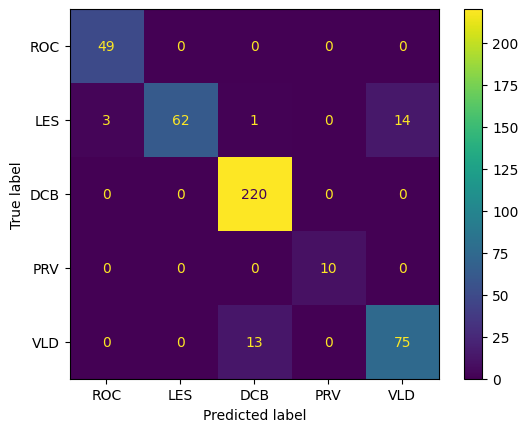

In [20]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix_clean = metrics.confusion_matrix(y_test_clean, model.predict(test_clean_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_clean, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()

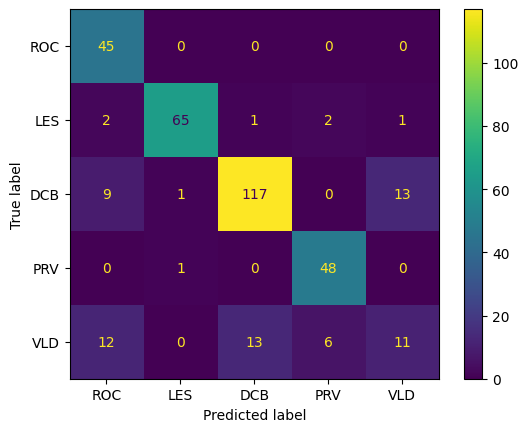

In [21]:

confusion_matrix_noisy = metrics.confusion_matrix(y_test_noisy, model.predict(test_noisy_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_noisy, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()